In [11]:
%matplotlib notebook 
import pytimber
import numpy as np
import scipy.io as sio
import matplotlib.dates as dates
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from datetime import datetime, timedelta


# Define Functions
def TStamps_Datetime(TimeStamps):

    ts_datetime = []
    for stamp in TimeStamps:
        try:
            ts_datetime.append(datetime.strptime(stamp,'%Y.%m.%d.%H.%M.%S.%f'))
        except:
            ts_datetime.append(datetime.strptime(stamp,'%Y/%m/%d %H:%M:%S.%f'))
        
    return ts_datetime

def Plot_Summary_Collect_Data(acc,ch):

    filenameLIU = 'Summary_Processed.mat'
    dataLIU =   sio.loadmat(filenameLIU, struct_as_record=False, squeeze_me=True)

    # Show LIU-BWS Measurements summary
    superplot = plt.figure(figsize = [10,9])
    ax0 = superplot.add_subplot(211)
    ax1 = superplot.add_subplot(212,sharex=ax0)
    #ax1 = superplot.add_subplot(313,sharex=ax0)
    
    for s in range(0,2):
        if s==0:
            scan = 'IN'
            Col = ['ob', 'og', 'ob', 'ob']
        else:
            scan = 'OUT'
            Col = ['or', 'oy', 'or', 'or']

        GOF = dataLIU['GOF_X2_'+scan]
        Sigmas = dataLIU['Sigmas_'+scan]
        Centres= dataLIU['Centres_'+scan]
        Imax = dataLIU['Imax_'+scan]
        QTot = dataLIU['Qtot_'+scan]
        AcqDly = dataLIU['InfoData_AcqDelay']
        HV = dataLIU['InfoData_HV']
        Amplit= dataLIU['AmplitG_'+scan]
        
        if s==0:
            Sigmas_IN = 1e3*np.abs(Sigmas)
            Centres_IN = Centres
        else:
            Sigmas_OUT = 1e3*np.abs(Sigmas)
            Centres_OUT = Centres
            
        if acc == 'PS':
            TStamp =dataLIU['InfoData_CycleName']
            TStamp_datetime = TStamps_Datetime(TStamp)
        else:
            TStamp = dataLIU['InfoData_CycleStamp']
            TStamp_datetime = TStamps_Datetime(TStamp)
  
        for c in range(ch[0],ch[1]):
            #ax0.plot(GOF[:,c],Col[c], markersize=3, label='CH ' + str(c) + ' ' +scan )
            ax0.plot(TStamp_datetime,1e3 * Centres[:, c], Col[c], markersize=3, label='CH ' + str(c) + ' ' +scan )
            ax1.plot(TStamp_datetime,1e3 * np.abs(Sigmas[:, c]), Col[c], markersize=3, label='CH ' + str(c) + ' ' +scan )


    #ax0.legend() 
    #ax0.grid()
    #ax0.set_title('GOF ' + acc)
    #ax0.set_ylabel('RMSE')
    #ax0.set_xlabel('Scan Number')
    #ax0.set_ylim(-0.5, 6)

    ax0.grid()
    ax0.xaxis.set_major_locator(dates.HourLocator(interval=1))   # every 1 hours
    ax0.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))  # hours and minutes
    ax0.set_title('Beam Centroid ' + acc)
    ax0.set_ylabel('Centroid [um]')
    #ax2.set_xlabel('Scan number')
    ax0.set_ylim(-3000,0)
    ax0.legend()

    ax1.grid()
    ax1.xaxis.set_major_locator(dates.HourLocator(interval=1))   # every 1 hours
    ax1.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))  # hours and minutes
    ax1.set_title('Beam Size ' + acc)
    ax1.set_ylabel('Sigma [um]')
    ax1.set_xlabel('UTC TimeStamp [HH:MM]')
    ax1.set_ylim(3000,5000)
    ax1.legend()

    plt.show()
    
    return AcqDly, Sigmas_IN, Sigmas_OUT, Centres_IN, Centres_OUT, TStamp, np.asarray(TStamp_datetime)


def Extract_Intensity_Timber(Device,Variable,t1,t2,ldb):
    # Get Intensity and TimeStamps
    Variable = Device + Variable
    d = ldb.get(Variable,t1,t2)
    timestamps_int,values_int = d[Variable] 

    # Prepare CPS TimeSTamps
    timestamps_readable = []
    timestamps_timedata = []
    for i in range(0,len(timestamps_int)):
        timestamps_readable.append(datetime.utcfromtimestamp(timestamps_int[i]).strftime('%Y-%m-%d %H:%M:%S.%f'))
        timestamps_timedata.append(datetime.strptime(timestamps_readable[-1],'%Y-%m-%d %H:%M:%S.%f'))
    
    return timestamps_timedata, values_int

def Do_Gauss_Fit(h_axis,values,hist_bins,col):

    def gauss(x, *p):
        a, b, c = p
        y = a * np.exp(-np.power((x - b), 2.) / (2. * c ** 2.))
        return y    
    
    n, bins, patches = h_axis.hist(values,hist_bins, alpha = 0.5, color = col)
    
    plotbins = []
    for i in range(0,len(bins)-1):
        plotbins.append((bins[i]+bins[i+1])/2)
    
    popt, pcov = curve_fit(gauss, plotbins, n, p0=[1, 1, 1])
    
    x_fit = np.arange(min(plotbins),max(plotbins),0.1)
    fit_y = gauss(x_fit,*popt)
    h_axis.plot(x_fit,fit_y,label = 'Entries:{:.0f}'.format(len(values))+'\nSigma:{:.2f}'.format(np.abs(popt[2]))+ '%',color=col)
	

<IPython.core.display.Javascript object>


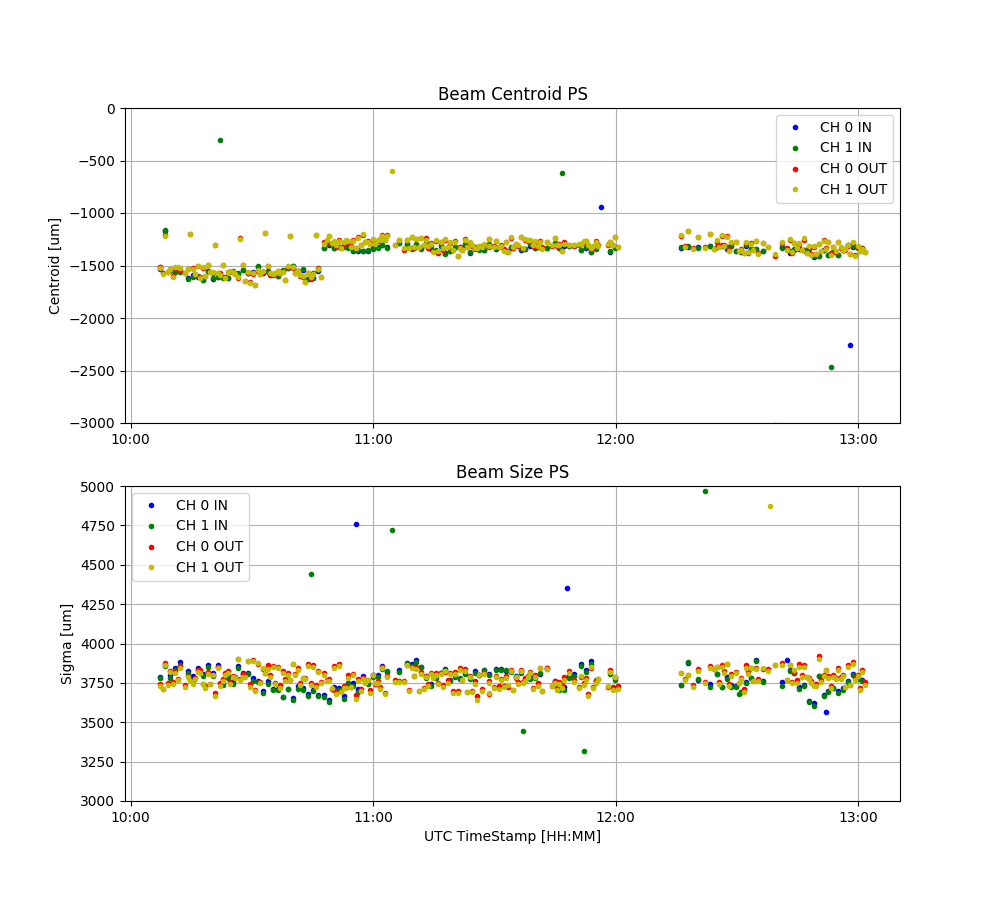

In [39]:
# Main program starts here
# *************************

# Collect Data from mat files and plot quick summary
AcqDly, Sigmas_CPS_IN,Sigmas_CPS_OUT,Centres_CPS_IN,Centres_CPS_OUT,TStamp_CPS,TStamp_CPS_datetime = Plot_Summary_Collect_Data('PS',[0,2])


<IPython.core.display.Javascript object>


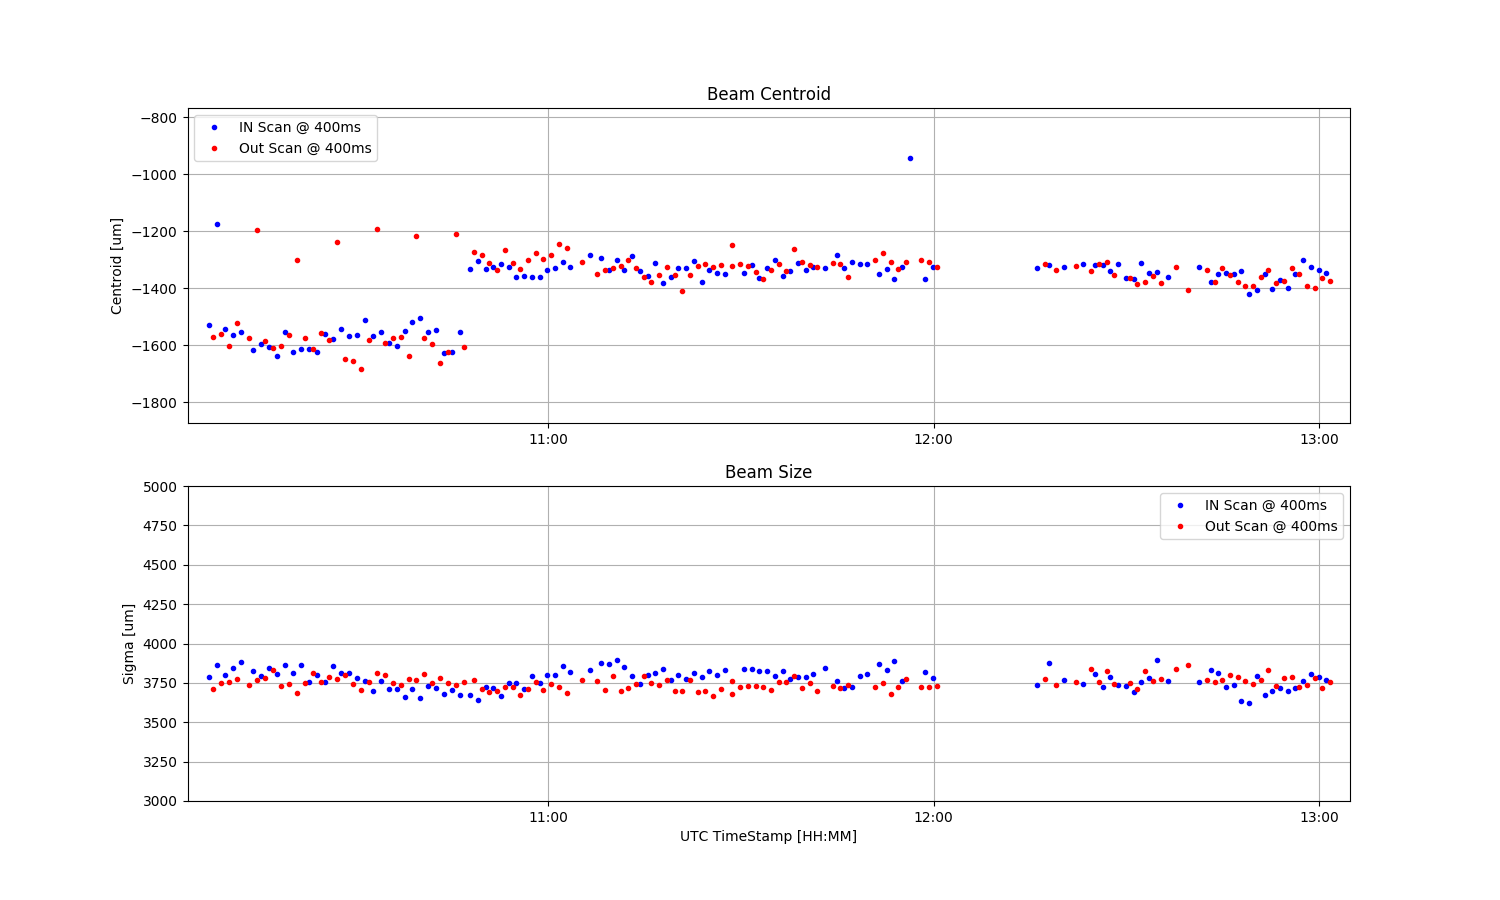

In [77]:
# Try to correlate Beam size with Intensity

# Pick Intensities and TimeStamps for CPS
ldb = pytimber.LoggingDB()
t1 = '2018-10-30 00:00:00.000'
t2 = '2018-10-31 00:00:00.000'

# INTENSITY VALUES AND TIMESTAMPS FROM CPS
# ****************************************     
timestamps_int_cps,values_int_cps = Extract_Intensity_Timber('PR.DCAFTINJ_1',':INTENSITY',t1,t2,ldb)

# MATCH CORRESPONDENCES INTENSITY WITH SCANNER
# ********************************************
timestamps_int_cps_corr = []
values_int_cps_corr = []
for idx,stamp in enumerate(TStamp_CPS_datetime):
    for idx_int, stamp_int in enumerate(timestamps_int_cps):
        if stamp == stamp_int:
            timestamps_int_cps_corr.append(timestamps_int_cps[idx_int])
            values_int_cps_corr.append(values_int_cps[idx_int])
values_int_cps_corr = np.asarray(values_int_cps_corr)

# Plot only Scans IN-OUT done at the same cycletime
# Programmed ADQ_DLAY are 74 and 349 (INOUT Delay was 300)

superplot1 = plt.figure(figsize = [15,9])
s1_ax0 = superplot1.add_subplot(211)
s1_ax1 = superplot1.add_subplot(212,sharex=s1_ax0)

Idx = np.where(AcqDly == 349)
Sigmas_In = Sigmas_CPS_IN[Idx]
Centres_IN = Centres_CPS_IN[Idx]
Intensity_IN = values_int_cps_corr[Idx]
InTstamps = TStamp_CPS_datetime[Idx]

Idx = np.where(AcqDly == 74)
Sigmas_Out = Sigmas_CPS_OUT[Idx]
Centres_OUT = Centres_CPS_OUT[Idx]
Intensity_OUT = values_int_cps_corr[Idx]
OutTstamps = TStamp_CPS_datetime[Idx]

s1_ax0.plot(InTstamps,1e3*Centres_IN[:,0],'ob',markersize=3, label = 'IN Scan @ 400ms')
s1_ax0.plot(OutTstamps,1e3*Centres_OUT[:,0],'or',markersize=3,label = 'Out Scan @ 400ms')

s1_ax1.plot(InTstamps,Sigmas_In[:,0],'ob',markersize=3, label = 'IN Scan @ 400ms')
s1_ax1.plot(OutTstamps,Sigmas_Out[:,0],'or',markersize=3,label = 'Out Scan @ 400ms')

s1_ax0.xaxis.set_major_locator(dates.HourLocator(interval=1))   # every 1hour 
s1_ax0.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))  # hours and minutes
s1_ax0.legend()
s1_ax0.set_title('Beam Centroid')
s1_ax0.set_ylabel('Centroid [um]')
s1_ax0.set_ylim(-3000,0)
s1_ax0.grid()

s1_ax1.xaxis.set_major_locator(dates.HourLocator(interval=1))   # every 1hour 
s1_ax1.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))  # hours and minutes
s1_ax1.legend()
s1_ax1.set_title('Beam Size')
s1_ax1.set_ylabel('Sigma [um]')
s1_ax1.set_xlabel('UTC TimeStamp [HH:MM]')
s1_ax1.set_ylim(3000,5000)
s1_ax1.grid()

plt.show()

<IPython.core.display.Javascript object>


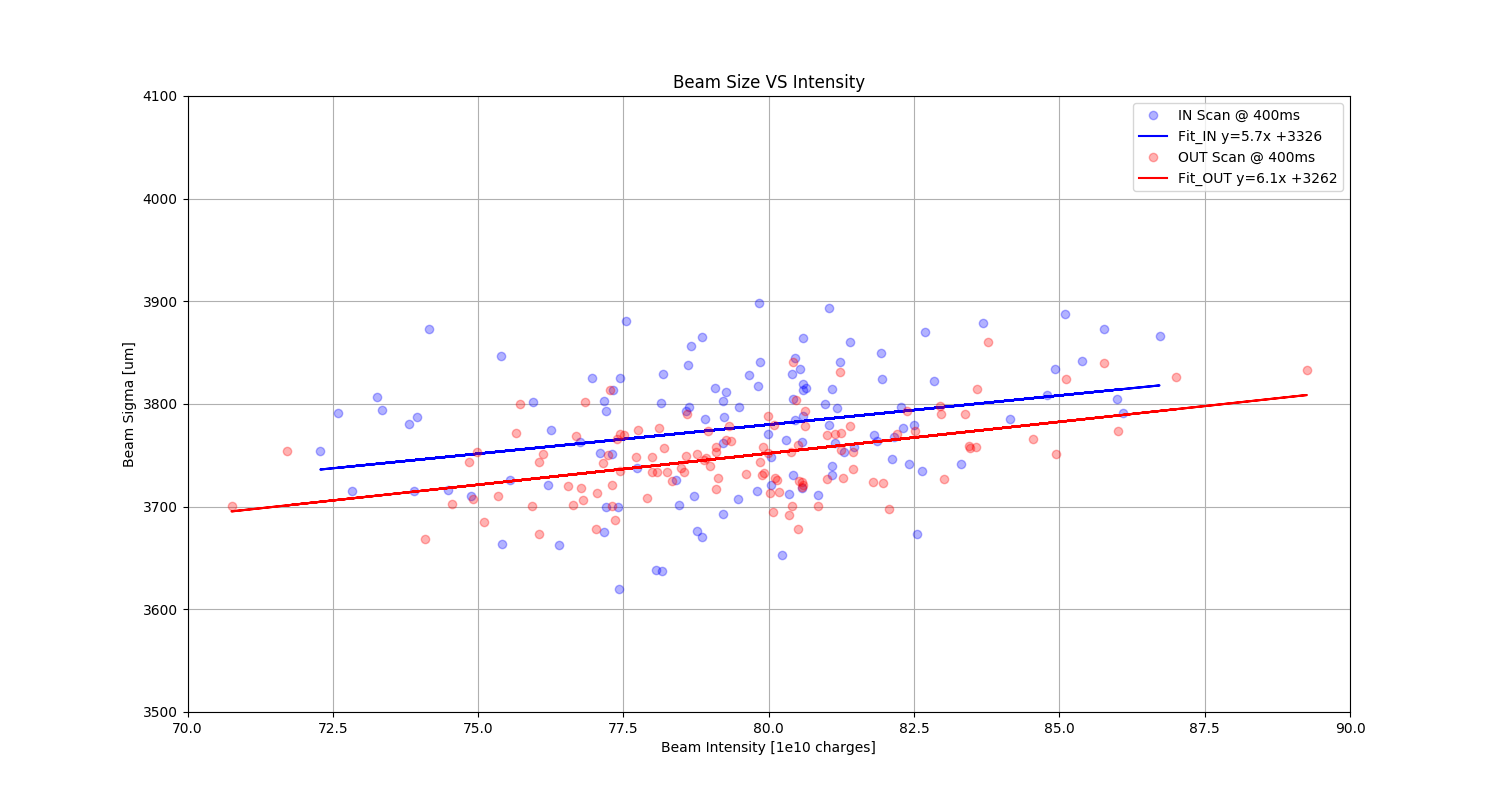

Sistematic IN/OUT difference on BeamSize: 0.74%
Precision IN : 1.6%
Precision OUT: 0.9%


In [76]:
# Plotting Correlation with Intensity and trying to obtain systematic difference IN/OUT in Beam Size
superplot2 = plt.figure(figsize = [15,8])
s2_ax0 = superplot2.add_subplot(111)
# Cleanup
Idx = np.where(Sigmas_In[:,0]>3000)
Sigmas_In_C=Sigmas_In[Idx,0]
Intensity_IN_C=Intensity_IN[Idx]

Idx = np.where(Sigmas_Out[:,0]>3000)
Sigmas_Out_C=Sigmas_Out[Idx,0]
Intensity_OUT_C=Intensity_OUT[Idx]

# Fit IN
fit_in = np.polyfit(Intensity_IN_C, Sigmas_In_C[0,:], 1)
fit_in_fn = np.poly1d(fit_in)
Res_in = (Sigmas_In_C[0,:]-fit_in_fn(Intensity_IN_C))/fit_in_fn(Intensity_IN_C)    

# Fit OUT
fit_out = np.polyfit(Intensity_OUT_C, Sigmas_Out_C[0,:], 1)
fit_out_fn = np.poly1d(fit_out)
Res_out = (Sigmas_Out_C[0,:]-fit_in_fn(Intensity_OUT_C))/fit_in_fn(Intensity_OUT_C)    


s2_ax0.plot(Intensity_IN_C,Sigmas_In_C[0,:],'ob',markersize=6, label = 'IN Scan @ 400ms', alpha = 0.3)
s2_ax0.plot(Intensity_IN_C,fit_in_fn(Intensity_IN_C),'b',label = 'Fit_IN y={:.1f}'.format(fit_in[0]) + 'x +{:.0f}'.format(fit_in[1]))

s2_ax0.plot(Intensity_OUT_C,Sigmas_Out_C[0,:],'or',markersize=6, label = 'OUT Scan @ 400ms', alpha = 0.3)
s2_ax0.plot(Intensity_OUT_C,fit_out_fn(Intensity_OUT_C),'r',label = 'Fit_OUT y={:.1f}'.format(fit_out[0]) + 'x +{:.0f}'.format(fit_out[1]))

s2_ax0.legend()
s2_ax0.set_ylim(3500,4100)
s2_ax0.set_xlim(70,90)
s2_ax0.set_title('Beam Size VS Intensity')
s2_ax0.set_ylabel('Beam Sigma [um]')
s2_ax0.set_xlabel('Beam Intensity [1e10 charges]')
s2_ax0.grid()
plt.show()

Difference = 100*np.abs(fit_out_fn(80)-fit_in_fn(80))/fit_out_fn(80)

print('Sistematic IN/OUT difference on BeamSize: {:.2}%'.format(Difference))
print('Precision IN : {:.2}%'.format(100*np.std(Res_in)))
print('Precision OUT: {:.2}%'.format(100*np.std(Res_out)))

In [ ]:
# Having a look at the situation with the operational BWS65H
Scanner = 'PR.BWS.65.H_ROT'
t1 = '2018-10-30 10:00:00.000'
t2 = '2018-10-30 13:15:00.000'

# Get TimeStamps in period
d=ldb.get(Scanner + ':ACQ_TIME',t1,t2)
TimeStamps_BWS = d[Scanner + ':ACQ_TIME'][1]
NumberScans = len(d[Scanner + ':ACQ_TIME'][1])

print('TotalTimeStamps: {:.0f}'.format(NumberScans))
#print(TimeStamps_BWS)

In [81]:
TimeStamps_BWS_DateTime = TStamps_Datetime(TimeStamps_BWS)

# Prepare Plots
superplot=plt.figure(figsize=[20,10])
ax_in = superplot.add_subplot(121)
ax_out = superplot.add_subplot(122)

# Get X and Y values for IN and OUT profiles
Sigmas_BWS65_IN = []
Sigmas_BWS65_OUT = []
Centres_BWS65_IN = []
Centres_BWS65_OUT = []
Dlay_BWS65 = []

for i in range(0,2):
    if i==0:
        ax = ax_in
        txt= 'IN'
        dx_ = ldb.get(Scanner + ':PROF_POSITION_IN',t1,t2) 
        dy_ = ldb.get(Scanner + ':PROF_DATA_IN',t1,t2)
        dx = dx_[Scanner + ':PROF_POSITION_IN'][1]
        dy = dy_[Scanner + ':PROF_DATA_IN'][1]
    else:
        ax = ax_out
        txt = 'OUT'
        dx_=  ldb.get(Scanner + ':PROF_POSITION_OUT',t1,t2) 
        dy_ = ldb.get(Scanner + ':PROF_DATA_OUT',t1,t2)
        dx = dx_[Scanner + ':PROF_POSITION_OUT'][1]
        dy = dy_[Scanner + ':PROF_DATA_OUT'][1]
        
    ax.set_xlabel('Position [mm]')
    ax.set_ylabel('Amplitude [a.u]')   
    ax.set_title(txt + ' Scans')
    ax.set_ylim(0,1.5)
    ax.set_xlim(-20,20)
    
    for c in range(0,NumberScans):
        ax.plot(1e-3*dx[c],dy[c],label = TimeStamps[c])
        
    ax.legend()
    ax.grid()
    
plt.show()


<IPython.core.display.Javascript object>

NameError: name 'txt' is not defined